In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import iqr
import matplotlib.pyplot as plt

import dtale
import pywedge as pw

from altair import Chart, X, Y, repeat
from common import display_side_by_side

from utils.common_transformers import DateHandler, DateDiff, DTypeTransformer

import json

In [75]:
df = pd.read_json("../intermediate_data/null_outlier_handled.json")
with open("../intermediate_data/dtypes.json") as f:
    mapping = json.load(f)

df = DTypeTransformer(mapping).fit_transform(df)

target_col = ["time_spent"]

copy = df.copy()

# Basic EDA

## Overview

In [23]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5429 entries, 0 to 5428
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_agent           5269 non-null   object        
 1   device_details         5429 non-null   object        
 2   date                   5429 non-null   datetime64[ns]
 3   purchased              5429 non-null   bool          
 4   added_in_cart          5429 non-null   bool          
 5   checked_out            5429 non-null   bool          
 6   time_spent             5429 non-null   float64       
 7   time_spent_is_outlier  5429 non-null   bool          
 8   client_agent_is_null   5429 non-null   bool          
dtypes: bool(5), datetime64[ns](1), float64(1), object(2)
memory usage: 238.6+ KB


None

In [24]:
df.describe()

,time_spent
count,5429.000000
mean,663.194292
std,1713.671664
min,14.400000
25%,22.699000
50%,98.312000
75%,600.463000
max,38494.025000


In [73]:
df["time_spent"].quantile(0.75) + iqr(df["time_spent"])*1.5

1467.109

In [26]:
df.head()

,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,time_spent_is_outlier,client_agent_is_null
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,True,False,False,236.886,False,False
1,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,True,False,False,1277.455,False,False
2,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,False,False,False,21.704,False,False
3,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,False,True,False,455.201,False,False
4,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,False,False,False,1164.877,False,False


In [76]:
df = DateHandler(["date"],date_format="%Y-%m-%d",drop_original_col=False).fit_transform(df)
df = DateDiff(["date"],date_format="%Y-%m-%d",drop_original_col=True).fit_transform(df)

In [77]:
df.dtypes

client_agent                      object
device_details                    object
purchased                           bool
added_in_cart                       bool
checked_out                         bool
time_spent                       float64
time_spent_is_outlier               bool
client_agent_is_null                bool
date_day                           int64
date_month                         int64
date_year                          int64
date_day_name                     object
date_day_num                       int64
date_is_weekend                     bool
date_close_to_month_start_end      int64
date_is_holiday                     bool
date_quater                        int64
date_date_diff                     int64
dtype: object

In [108]:
cat_cols = df.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    print(col)
    
    vc = pd.DataFrame(df[col].value_counts(dropna=False,normalize=True))
    vc.columns = ["% Count"]
    vc.sort_values("% Count",ascending=False)
    print(f"No of unique categories : {len(vc)}")
    display(vc.head(7))

client_agent
No of unique categories : 699


,% Count
"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Mobile/11D201",0.038497
Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7.0; Touch; rv:11.0) like Gecko,0.030024
NaN,0.029471
Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko,0.027261
Product/4.2.0 iPhone/7.1.1,0.026893
Product/4.7.0 iPhone/8.1.2,0.026524
"Mozilla/5.0 (iPhone; CPU iPhone OS 8_1 like Mac OS X) AppleWebKit/600.1.4 (KHTML, like Gecko) Mobile/12B411",0.020998


device_details
No of unique categories : 17


,% Count
iPhone - iOS,0.279057
Desktop - Chrome,0.150120
iPhone - Web,0.122490
Android Phone - Android,0.060048
Desktop - Safari,0.057653
Desktop - IE,0.053785
iPad - Web,0.053233


purchased
No of unique categories : 2


,% Count
False,0.840855
True,0.159145


added_in_cart
No of unique categories : 2


,% Count
False,0.837908
True,0.162092


checked_out
No of unique categories : 2


,% Count
False,0.982501
True,0.017499


time_spent_is_outlier
No of unique categories : 2


,% Count
False,0.876589
True,0.123411


client_agent_is_null
No of unique categories : 2


,% Count
False,0.970529
True,0.029471


date_day_name
No of unique categories : 7


,% Count
Sunday,0.163566
Tuesday,0.159514
Monday,0.158224
Wednesday,0.141831
Thursday,0.132253
Friday,0.125069
Saturday,0.119543


date_is_weekend
No of unique categories : 2


,% Count
False,0.716891
True,0.283109


date_is_holiday
No of unique categories : 2


,% Count
False,0.989132
True,0.010868


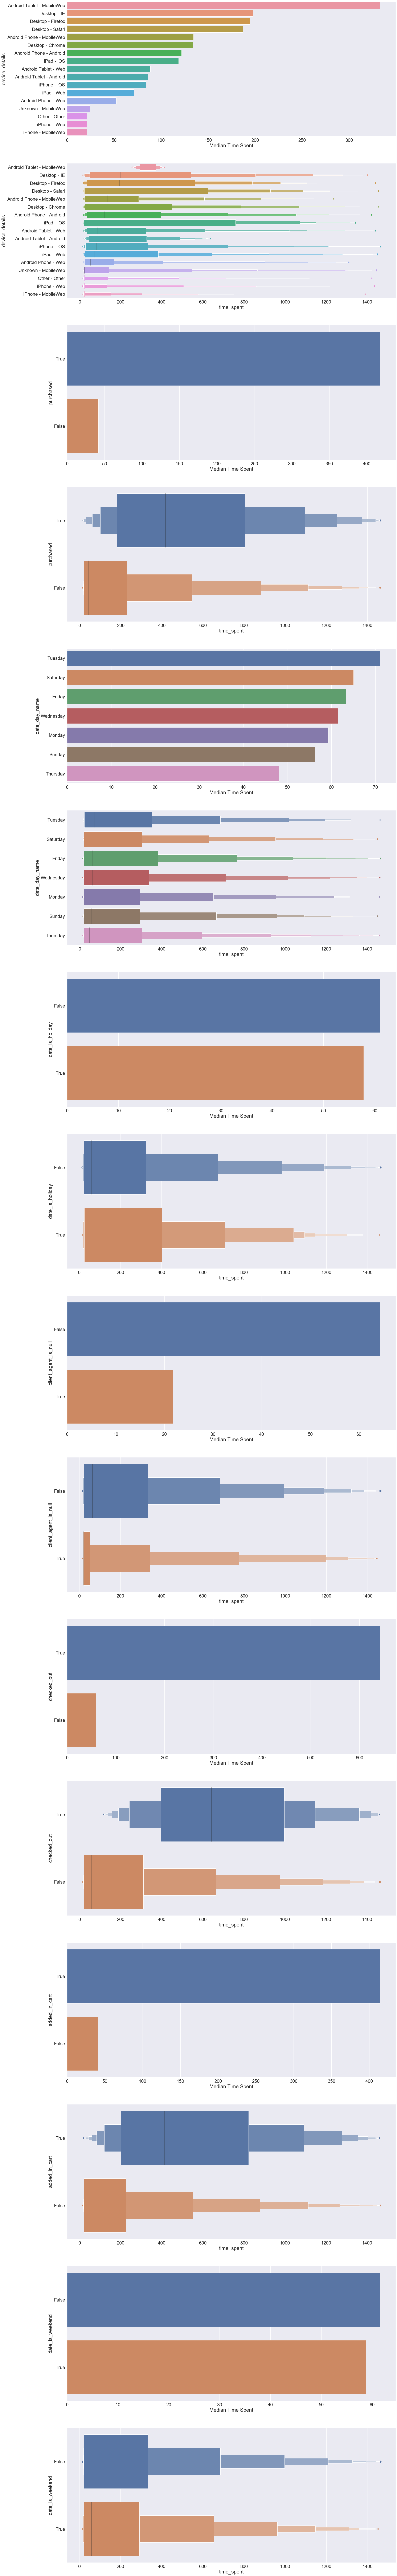

In [110]:
target_col = "time_spent"
target_outlier_col = "time_spent_is_outlier"
sub = df.query("time_spent<1467")

cat_cols = list(set(cat_cols).difference(set(["client_agent","date",target_outlier_col])))
num_rows = len(cat_cols)

fig, axes = plt.subplots(nrows=num_rows*2, ncols=1, figsize=(28,num_rows*2*14))
ax= axes.flatten()

for i in range(0,num_rows*2,2):
    col = cat_cols[i//2]
    a=pd.DataFrame(sub.groupby(col)[target_col].median()).sort_values(target_col,ascending=False)
    a=a.reset_index()
    sns.set(font_scale = 2)
    sns_ax = sns.barplot(x=target_col,y=col,data=a,ax=ax[i],orient="h",order=list(a[col].values))
    sns_ax.set(xlabel='Median Time Spent')
    sns.boxenplot(x=target_col,y=col,data=sub,orient="h",ax=ax[i+1],order=list(a[col].values))

  

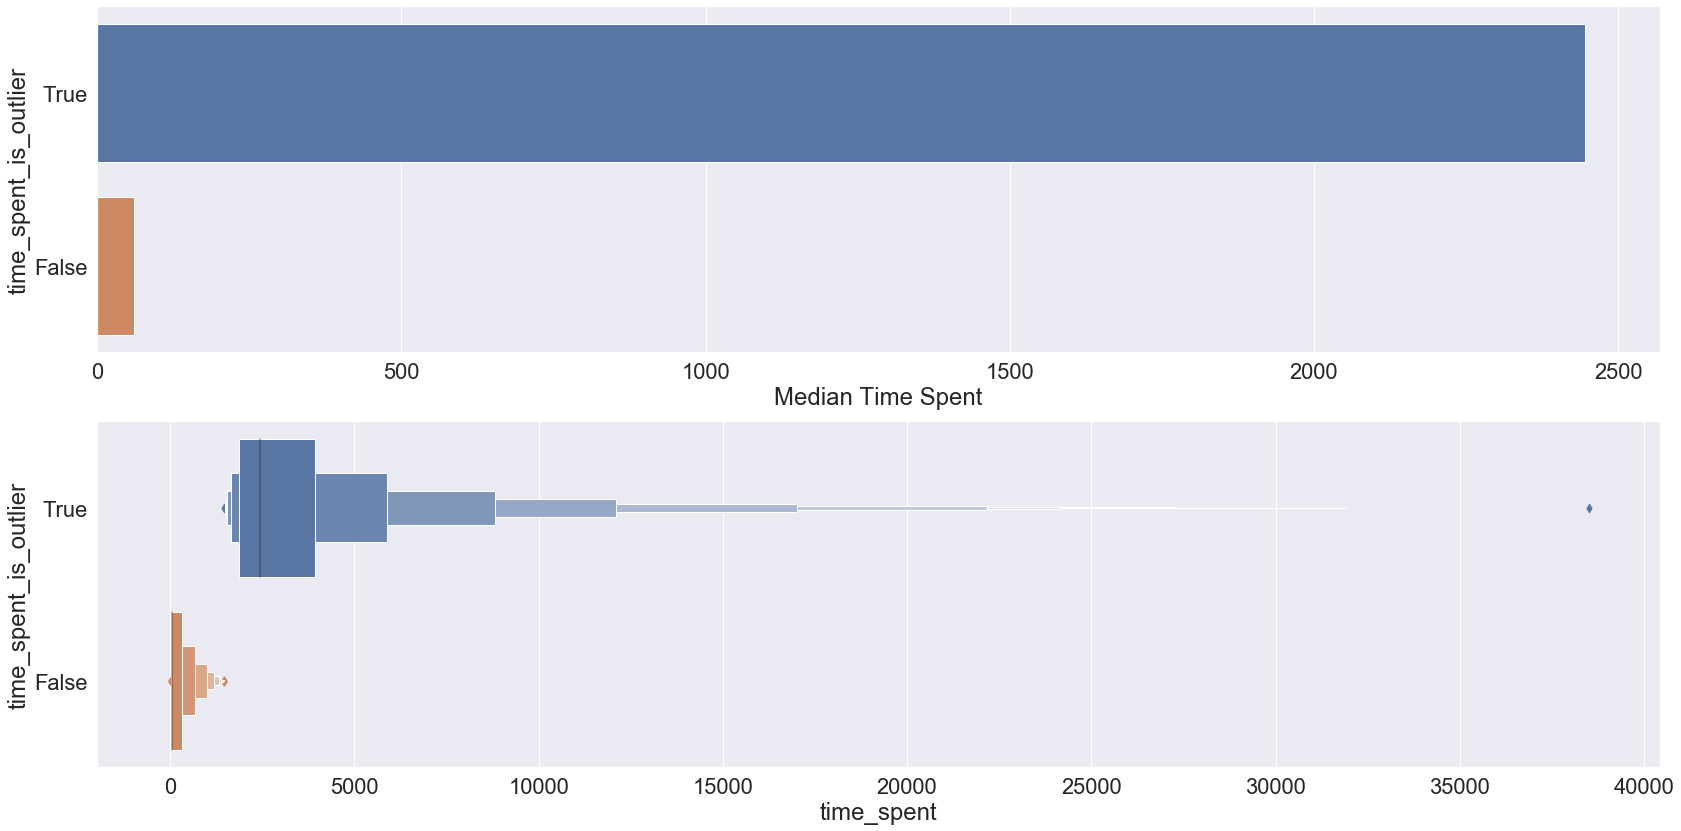

In [118]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(28,14))
ax= axes.flatten()
a=pd.DataFrame(df.groupby(target_outlier_col)[target_col].median()).sort_values(target_col,ascending=False)
a=a.reset_index()
sns.set(font_scale = 2)
sns_ax = sns.barplot(x=target_col,y=target_outlier_col,data=a,orient="h",order=list(a[target_outlier_col].values),ax=ax[0])
sns_ax.set(xlabel='Median Time Spent')
sns.boxenplot(x=target_col,y=target_outlier_col,data=df,orient="h",order=list(a[target_outlier_col].values),ax=ax[1])
plt.show()

In [66]:
#sns.pairplot(df)

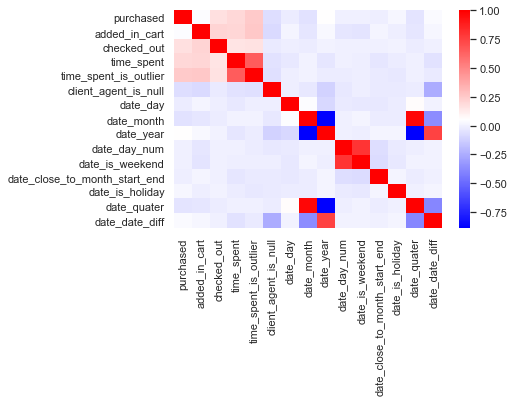

In [67]:
sns.set(font_scale = 1)
sns.heatmap(df.corr(),cmap="bwr")

In [68]:
df.head(n=2)

,client_agent,device_details,purchased,added_in_cart,checked_out,time_spent,time_spent_is_outlier,client_agent_is_null,date_day,date_month,date_year,date_day_name,date_day_num,date_is_weekend,date_close_to_month_start_end,date_is_holiday,date_quater,date_date_diff
0,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,True,False,False,236.886,False,False,22,1,2020,Wednesday,2,False,0,False,1,261
1,Product/8.0 iPhone/8.1.3,iPhone - iOS,True,False,False,1277.455,False,False,27,2,2020,Thursday,3,False,1,False,1,297


In [71]:
df.drop(["client_agent","device_details","time_spent_is_outlier","date_day_name"],inplace=True,axis=1)

In [72]:
df.to_json("../intermediate_data/basic_fe.json")

# Feature Engineering & Advanced EDA 

In [24]:
dtale.show(df,ignore_duplicate=True)

In [21]:
mc=pw.Pywedge_Charts(df.dropna(),c=None,y="Final_Marks")
charts = mc.make_charts();

HTML(value='<h2>Pywedge Make_Charts </h2>')

HTML(value='<h4><em>Charts compiled by Pywedge make_charts </em></h4>')

## Discrete Target

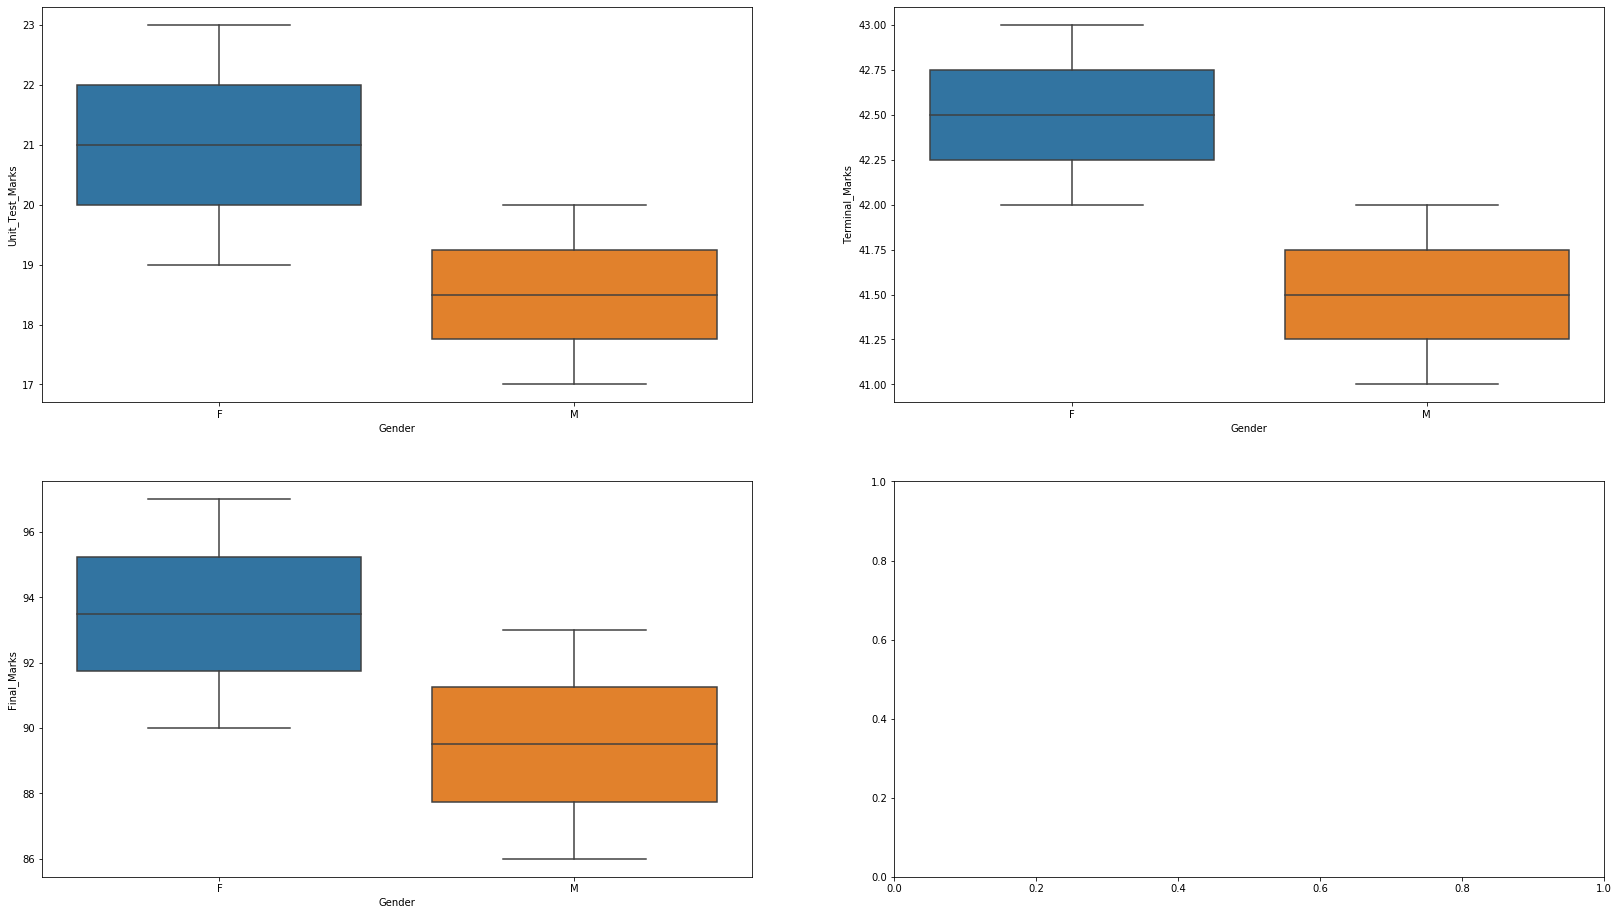

In [107]:
target_col = "Gender"
num_cols = df.select_dtypes(include=np.number)

num_rows = int(np.ceil(len(num_cols.columns) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(num_cols.columns,0):
    axes = ax[index]
    sns.boxplot(data=df,x=target_col,y=col,ax=axes,)
  

In [172]:
cat_cols_names = list(set(cat_cols.columns).difference(set([target_col])))
dfs = []
for index,col in enumerate(cat_cols_names,0):
    a = pd.DataFrame(df.groupby("Gender")[col].value_counts(dropna=False,normalize=True))
    a.columns=["% Count"]
    dfs.append(a)

In [173]:
display_side_by_side(*dfs)

% Count 
 
 
 Gender 
 Performance 
 
 
 
 
 
 F 
 NaN 
 0.5 
 
 
 A+ 
 0.5 
 
 
 M 
 A 
 0.5 
 
 
 B 
 0.5

## Continuous Target

### Normality Test

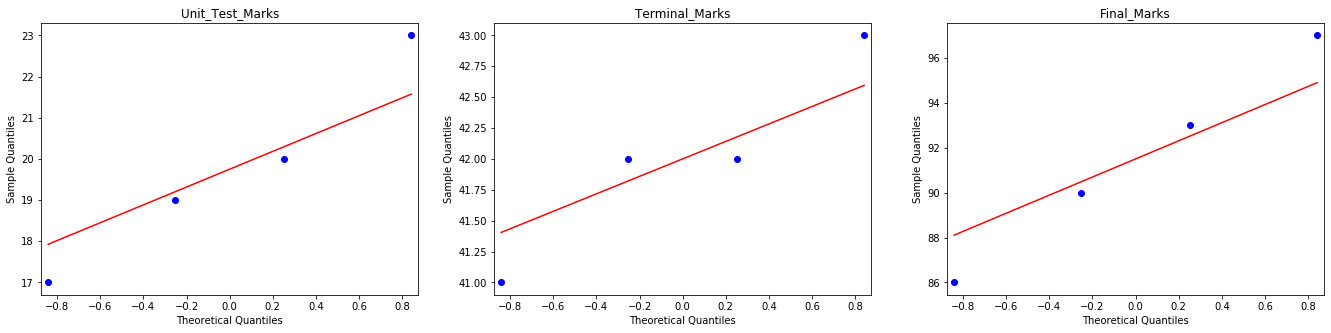

In [22]:
numeric= df.select_dtypes(include=[int,float])
num_numeric_cols = numeric.shape[1]
num_rows = int(np.ceil(num_numeric_cols / 3))

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(23,5))
ax= axes.flatten()
for index,col in enumerate(numeric.columns,0):
    axes = ax[index]
    axes.set_title(col)
    qqplot(numeric[col], line='s',ax=axes)
    

# Feature Engineering